In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import numpy as np
%matplotlib inline
torch.manual_seed(42)
import random
from PIL import Image

In [ ]:
import os
import pandas as pd

In [ ]:
print(f"CUDA is available? {torch.cuda.is_available()}")
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

CUDA is available? False
cpu


In [ ]:
# Define root directory from Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal



In [ ]:
dataset_path = './dataset'
covid_dataset_path = '/content/drive/My Drive/covid-chestxray-dataset-master/'

In [ ]:
meta_data = pd.read_csv(covid_dataset_path+'metadata.csv',index_col=[0])
meta_data.head(10)

In [ ]:
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)


for (i, row) in df.iterrows():
   
    if row["finding"] != "COVID-19, ARDS":
        continue

    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    if not os.path.exists(imagePath):
        continue

    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    shutil.move(imagePath, outputPath)

In [ ]:
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)


for (i, row) in df.iterrows():
    if row["finding"] != "COVID-19":
        continue

    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    if not os.path.exists(imagePath):
        continue


    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])


    shutil.move(imagePath, outputPath)

In [ ]:
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)


for (i, row) in df.iterrows():
    if row["finding"] == "COVID-19":
        continue

    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    if not os.path.exists(imagePath):
        continue

    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    shutil.move(imagePath, outputPath)

In [ ]:
%%bash
pip install split-folders
pip install split-folders tqdm

In [ ]:
%%bash
rm -rf split_dataset
mkdir -p split_dataset

In [ ]:
import split_folders
split_folders.ratio('/content/dataset', output="/content/split_dataset", seed=1337, ratio=(.6, .2, .2)) # default values

Copying files: 789 files [00:01, 593.42 files/s]


In [ ]:
set_perms = torch.zeros([64,9],dtype=torch.int32)
for g in range(64):
    set_perms[g] = torch.randperm(9)
  
print(set_perms.size())


torch.Size([64, 9])


In [ ]:
perm_inds = [(0,0),(75,0),(150,0),(150,75),(75,75),(0,75),(150,150),(75,150),(0,150)]

img_mean = 0.5
img_std = 0.5

tail_transform = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.RandomCrop(64),
     transforms.Resize((75, 75)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])
     ])
    
    
def permute3x3(images,set_perms):


    target = torch.LongTensor(images.size()[0])

    p_images = torch.FloatTensor(images.size())

    perms = torch.LongTensor(images.size()[0], 9)

    tmp = torch.LongTensor(3,75,75)

    for i in range(images.size()[0]):
        n = random.randint(0,63)
        p = set_perms[n]
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            temp = images[i, :, sr:sr+75, sc:sc+75]
            out = tail_transform(temp)
            p_images[i, :, tr:tr+75, tc:tc+75] = out
        target[i] = n
    return(p_images, target)

def restore(p_images, target):
  images = torch.FloatTensor(p_images.size())
  for i in range(images.size()[0]):
    x  = target[i] 
    perm = set_perms[x]

    for j in range(9):          
        sr, sc = perm_inds[j]            
        tr, tc = perm_inds[perm[j]]
        images[i, :, sr:sr+75, sc:sc+75] = p_images[i, :, tr:tr+75, tc:tc+75]
  return images

    
def imshow(img, title=None):
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Permuted Image')

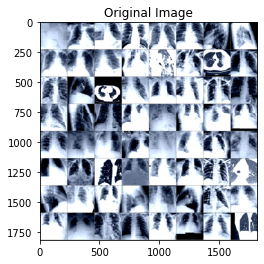

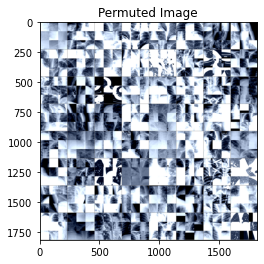

In [ ]:
batch_size = 64
dataset_dir = '/content/split_dataset/'

transform = transforms.Compose(
    [transforms.Resize(256,Image.BILINEAR),
     transforms.RandomCrop(225),
     transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor()])


test_set = torchvision.datasets.ImageFolder(root = dataset_dir+'test' ,transform=transform)
train_set = torchvision.datasets.ImageFolder(root = dataset_dir+'train' ,transform=transform)
val_set = torchvision.datasets.ImageFolder(root = dataset_dir+'val' ,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=0,drop_last= True)

dataiter = iter(train_loader)
images, labels = next(dataiter)

p_images , target = permute3x3(images, set_perms)


plt.figure()
plt.title('Original Image')
imshow(torchvision.utils.make_grid(restore(p_images, target)))


plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Permuted Image')


In [ ]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,shuffle=True, num_workers=0,drop_last= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=0,drop_last= True)
print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(val_loader)))
print('Number of test batches: {}'.format(len(test_loader)))
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

Number of training batches: 7
Number of validation batches: 2
Number of test batches: 2


In [ ]:
# Imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Define class
class JigsawConv(nn.Module):
    
    # Constructor
    def __init__(self):
        # Call parent constructor
        super().__init__();
        # Create convolutional layers
        self.conv_layers1 = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers2 = nn.Sequential(
             # Layer 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers3 = nn.Sequential(
            # Layer 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),
            #nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers4 = nn.Sequential(
             # Layer 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),
            #nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_layers5 = nn.Sequential(
             # Layer 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),    
        )
        self.fc6_layers = nn.Sequential(
          nn.Linear(256*3*3, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
        )
    # Forward
    def forward(self, x):
        x = self.conv_layers1(x)
        x = self.conv_layers2(x)
        x = self.conv_layers3(x)
        x = self.conv_layers4(x)
        x = self.conv_layers5(x)
        x = x.view(x.size(0), -1)
        x = self.fc6_layers(x)
        return x
# Define class
class JigsawFullyC(nn.Module):
    
    # Constructor
    def __init__(self):
        # Call parent constructor
        super().__init__();
        # Create convolutional layers
        self.fc7_layers = nn.Sequential(
            # FC layer fc7
            nn.Linear(9*1024, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.fc8_layers = nn.Sequential(
          # FC layer fc8
          nn.Linear(4096, 64),
          #nn.Dropout(0.5),
          #nn.ReLU(),
          #nn.Linear(1024, 64),
          #nn.Softmax()
      )
    # Forward
    def forward(self, x):
        x = self.fc7_layers(x)
        x = self.fc8_layers(x)
        return x

class JigsawNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_net = JigsawConv()
        self.fully_net = JigsawFullyC()
    
    def forward(self, x):
     
        x0 = self.conv_net(x[:, :, 0:75,150:225])
        x1 = self.conv_net(x[:, :, 0:75, 75:150])
        x2 = self.conv_net(x[:, :, 0:75, 0:75])
        x3 = self.conv_net(x[:, :, 75:150, 150:225])
        x4 = self.conv_net(x[:, :, 75:150, 75:150])
        x5 = self.conv_net(x[:, :, 75:150, 0:75])
        x7 = self.conv_net(x[:, :, 150:225, 75:150])    
        x6 = self.conv_net(x[:, :, 150:225, 150:225])
        x8 = self.conv_net(x[:, :, 150:225 ,0:75])
        # Cat
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7 , x8], dim=1)
        # Dense layer
        x = self.fully_net(x)
        #print("Uscita Jigsaw: ",x.size())
        return x

In [ ]:
import torch.optim as optim
model_save = '/content/drive/My Drive/Checkpoint'
#model = torch.load(model_save)
model = JigsawNet()
model.to(dev)
print(model)
# Create optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}
epoch = 200

try:
    for epoch in range(epoch):
      # Initialize variables for computing average loss/accuracy
      epoch_loss_sum = {"train": 0, "val": 0, "test": 0}
      epoch_loss_cnt = {"train": 0, "val": 0, "test": 0}
      epoch_accuracy_sum = {"train": 0, "val": 0, "test": 0}
      epoch_accuracy_cnt = {"train": 0, "val": 0, "test": 0}
      for split in ["train", "val", "test"]:
          # Set network mode (train or eval)
          if split == 'train':
              #model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.
              model.train()
              torch.set_grad_enabled(True)
              print ("mode train actived, ", split)
          elif split == 'val'or split == 'test':
              model.eval()
              torch.set_grad_enabled(False)
              print ("mode eval actived, ", split)  
          # Process all data in split
          for i,(input,_) in enumerate(loaders[split]):
              # Move to device
              x_in, _ , target = permute3x3(input,set_perms)
              input = x_in.to(dev)
              target = target.to(dev)
              # Compute output
              output = model(input) 
              # Compute loss
              loss = F.cross_entropy(output, target)
              # Update variables for average epoch loss            
              epoch_loss_sum[split] += loss.item()             
              epoch_loss_cnt[split] += 1            
              # Compute accuracy
              pred = output.argmax(1)
              correct = pred.eq(target).sum().item()
              accuracy = correct/input.size(0)
              # Update variables for average epoch accuracy
              epoch_accuracy_sum[split] += accuracy
              epoch_accuracy_cnt[split] += 1
              # Backward and optimize
              if split == "train":
                  # Reset gradients
                  optimizer.zero_grad()
                  # Compute gradients faccio backpropagation 
                  loss.backward()
                  # Optimize aggiorno parametri 
                  optimizer.step()
              torch.save(model, model_save)
      # Compute average epoch loss/accuracy
      avg_train_loss = epoch_loss_sum["train"]/epoch_loss_cnt["train"]
      avg_train_accuracy = epoch_accuracy_sum["train"]/epoch_accuracy_cnt["train"]
      avg_val_loss = epoch_loss_sum["val"]/epoch_loss_cnt["val"]
      avg_val_accuracy = epoch_accuracy_sum["val"]/epoch_accuracy_cnt["val"]
      avg_test_loss = epoch_loss_sum["test"]/epoch_loss_cnt["test"]
      avg_test_accuracy = epoch_accuracy_sum["test"]/epoch_accuracy_cnt["test"]
      print(f"Epoch {epoch+1}:",
      f"TrL={avg_train_loss:.4f},",
      f"TrA={avg_train_accuracy:.4f},",
      f"VL={avg_val_loss:.4f},",
      f"VA={avg_val_accuracy:.4f},",
      f"TeL={avg_test_loss:.4f},",
      f"TeA={avg_test_accuracy:.4f},")
      # Append average values to history lists
      history_loss["train"].append(avg_train_loss)
      history_loss["val"].append(avg_val_loss)
      history_loss["test"].append(avg_test_loss)
      history_accuracy["train"].append(avg_train_accuracy)
      history_accuracy["val"].append(avg_val_accuracy)
      history_accuracy["test"].append(avg_test_accuracy) 
except KeyboardInterrupt:
    print("Interrupted")
finally:
    # Plot loss
    plt.title("Loss")
    for split in ["train", "val", "test"]:
        plt.plot(history_loss[split], label=split)
    plt.legend()
    plt.show()
    # Plot accuracy
    plt.title("Accuracy")
    for split in ["train", "val", "test"]:
        plt.plot(history_accuracy[split], label=split)
    plt.legend()
    plt.show()


In [ ]:
# Let us try some test images.
test_data_iter = iter(test_loader)
test_images, _ = test_data_iter.next()
p_images, perms, target = permute3x3(test_images, set_perms)

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Inputs')
plt.show()


model.eval()
with torch.no_grad():
    output = model(p_images.to(dev))
_,pred = output.max(1)


plt.figure()
imshow(torchvision.utils.make_grid(restore(p_images, pred)))
plt.title('RestoredModel')
plt.show()

plt.figure()
imshow(torchvision.utils.make_grid(restore(p_images, target)))
plt.title('RestoredModelTargeting')
plt.show()


plt.figure()
imshow(torchvision.utils.make_grid(restore3x3(p_images, perms)))
plt.title('RestoredWithPermutation')
plt.show()



**TRANSFERT LEARNING **

In [ ]:
model_tl = torch.load(model_save)
#model_tl = model
model_tl= model_tl.conv_net
model_tl.fc6_layers =  nn.Sequential(
          nn.Linear(36864, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(1024, 2),
        )
model_tl_save = '/content/drive/My Drive/Checkpoint_tf'
model_tl.to(dev)
optimizer = optim.Adam(model_tl.parameters(), lr=0.001)
print(model_tl)

In [ ]:
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}
epoch = 50
try:
  for epoch in range(epoch):
      # Initialize variables for computing average loss/accuracy
      epoch_loss_sum = {"train": 0, "val": 0, "test": 0}
      epoch_loss_cnt = {"train": 0, "val": 0, "test": 0}
      epoch_accuracy_sum = {"train": 0, "val": 0, "test": 0}
      epoch_accuracy_cnt = {"train": 0, "val": 0, "test": 0}
      for split in ["train", "val", "test"]:
          # Set network mode (train or eval)
          if split == 'train':
              model_tl.train()
              torch.set_grad_enabled(True)
              print ("mode train actived, ", split)
          elif split == 'val'or split == 'test':
              model_tl.eval()
              torch.set_grad_enabled(False)
              print ("mode eval actived, ", split)  
          # Process all data in split
          for i,(input,target) in enumerate(loaders[split]):
              # Move to device
              input = input.to(dev)
              target = target.to(dev)
              # Compute output
              output = model_tl(input) 
              # Compute loss
              loss = F.cross_entropy(output, target)
              # Update variables for average epoch loss            
              epoch_loss_sum[split] += loss.item()             
              epoch_loss_cnt[split] += 1            
              # Compute accuracy
              pred = output.argmax(1)
              correct = pred.eq(target).sum().item()
              accuracy = correct/input.size(0)  
              # Update variables for average epoch accuracy
              epoch_accuracy_sum[split] += accuracy
              epoch_accuracy_cnt[split] += 1
              # Backward and optimize
              if split == "train":
                  # Reset gradients
                  optimizer.zero_grad()
                  # Compute gradients
                  loss.backward()
                  # Optimize
                  optimizer.step()
              torch.save(model, model_tl_save)
      # Compute average epoch loss/accuracy
      avg_train_loss = epoch_loss_sum["train"]/epoch_loss_cnt["train"]
      avg_train_accuracy = epoch_accuracy_sum["train"]/epoch_accuracy_cnt["train"]
      avg_val_loss = epoch_loss_sum["val"]/epoch_loss_cnt["val"]
      avg_val_accuracy = epoch_accuracy_sum["val"]/epoch_accuracy_cnt["val"]
      avg_test_loss = epoch_loss_sum["test"]/epoch_loss_cnt["test"]
      avg_test_accuracy = epoch_accuracy_sum["test"]/epoch_accuracy_cnt["test"]
      print(f"Epoch {epoch+1}:",
      f"TrL={avg_train_loss:.4f},",
      f"TrA={avg_train_accuracy:.4f},",
      f"VL={avg_val_loss:.4f},",
      f"VA={avg_val_accuracy:.4f},",
      f"TeL={avg_test_loss:.4f},",
      f"TeA={avg_test_accuracy:.4f},")
      # Append average values to history lists
      history_loss["train"].append(avg_train_loss)
      history_loss["val"].append(avg_val_loss)
      history_loss["test"].append(avg_test_loss)
      history_accuracy["train"].append(avg_train_accuracy)
      history_accuracy["val"].append(avg_val_accuracy)
      history_accuracy["test"].append(avg_test_accuracy)
except KeyboardInterrupt:
    print("Interrupted")
finally:
    # Plot loss
    plt.title("Loss")
    for split in ["train", "val", "test"]:
        plt.plot(history_loss[split], label=split)
    plt.legend()
    plt.show()
    # Plot accuracy
    plt.title("Accuracy")
    for split in ["train", "val", "test"]:
        plt.plot(history_accuracy[split], label=split)
    plt.legend()
    plt.show()


In [ ]:
# Get random sample from test set
idx = random.randint(0, len(test_set)-1)
input, label = test_set[idx]
# Normalize and show image
input_show = (input - input.min())/(input.max() - input.min())
plt.imshow(input_show.permute(1,2,0).numpy())
plt.axis('off')
# Predict class
model_tl.eval()
with torch.no_grad():
    output = model_tl(input.unsqueeze(0).to(dev))
_,pred = output.max(1)
pred = pred.item()


print(f"Predicted: {pred} (correct: {label})")